In [53]:
import pymssql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data


In [3]:
tables = [
    'building_permits',
    'mortgage_rates',
    'house_prices',
    'median_income',
]

query = f"SELECT * FROM {tables[0]}" # Query Example
bp_df = sql_query(query)

In [4]:
query = f"SELECT * FROM {tables[1]}" # Query Example
mr_df = sql_query(query)

In [5]:
query = f"SELECT * FROM {tables[2]}" # Query Example
hp_df = sql_query(query)

In [8]:
query = f"SELECT * FROM {tables[3]} WHERE AgeGroup = '45-64'" # Query Example
mi_df = sql_query(query)

In [23]:
mi_df.dtypes

Year             int64
County          object
FIPS            object
AgeGroup        object
MedianIncome     int64
dtype: object

In [24]:
hp_df['Year'] = hp_df['Year'].astype('int64')

In [25]:
hp_df.dtypes

County               object
Date                 object
FIPS                 object
MedianHousePrice    float64
Month                object
State                object
Year                  int64
hp_df                 int64
dtype: object

In [20]:
hp_df['MedianHousePrice'] = hp_df.MedianHousePrice.apply(lambda x: None if x == '' else int(float(x)))

In [22]:
hp_df.dtypes

County               object
Date                 object
FIPS                 object
MedianHousePrice    float64
Month                object
State                object
Year                 object
hp_df                 int64
dtype: object

In [26]:
joined_df = pd.merge(mi_df, hp_df, left_on = ['FIPS', 'Year'], right_on = ['FIPS', 'Year'], how = 'outer')

In [35]:
reduced = joined_df[['Year','Month','County_y', 'MedianIncome','MedianHousePrice']].copy()

In [36]:
reduced['MedianIncome'] = reduced['MedianIncome'] / 12

In [37]:
reduced

,Year,Month,County_y,MedianIncome,MedianHousePrice
0,2005,Jan,Baldwin County,3894.583333,161268.0
1,2005,Feb,Baldwin County,3894.583333,163044.0
2,2005,Mar,Baldwin County,3894.583333,164869.0
3,2005,Apr,Baldwin County,3894.583333,167106.0
4,2005,May,Baldwin County,3894.583333,169395.0
...,...,...,...,...,...
758070,2001,Aug,Hancock County,NaN,107352.0
758071,2001,Sep,Hancock County,NaN,107712.0
758072,2001,Oct,Hancock County,NaN,107980.0
758073,2001,Nov,Hancock County,NaN,108306.0


In [44]:
monthly_mr = mr_df[(mr_df.Month != 'ANNUAL AVERAGE')].copy()

In [45]:
monthly_mr

,Year,Month,AverageRate,AveragePoints
1,1978,APRIL,9.35,1.3
2,1978,AUGUST,9.78,1.3
3,1978,DECEMBER,10.35,1.4
4,1978,FEBRUARY,9.14,1.3
5,1978,JANUARY,9.01,1.3
...,...,...,...,...
580,2022,MARCH,4.17,0.8
581,2022,MAY,NaN,NaN
582,2022,NOVEMBER,NaN,NaN
583,2022,OCTOBER,NaN,NaN


In [46]:
import datetime as dt

def convert_date(year, month):
    converted = dt.datetime.strptime(f"{year}-{month}-01", '%Y-%B-%d')
    return converted

monthly_mr['Date'] = monthly_mr.apply(lambda row: convert_date(row.Year, row.Month), axis = 1)

In [47]:
monthly_mr

,Year,Month,AverageRate,AveragePoints,Date
1,1978,APRIL,9.35,1.3,1978-04-01
2,1978,AUGUST,9.78,1.3,1978-08-01
3,1978,DECEMBER,10.35,1.4,1978-12-01
4,1978,FEBRUARY,9.14,1.3,1978-02-01
5,1978,JANUARY,9.01,1.3,1978-01-01
...,...,...,...,...,...
580,2022,MARCH,4.17,0.8,2022-03-01
581,2022,MAY,NaN,NaN,2022-05-01
582,2022,NOVEMBER,NaN,NaN,2022-11-01
583,2022,OCTOBER,NaN,NaN,2022-10-01


In [48]:
monthly_mr.sort_values(by = 'Date', inplace = True)

In [51]:
monthly_mr.reset_index(drop = True, inplace = True)

In [52]:
monthly_mr

,Year,Month,AverageRate,AveragePoints,Date
0,1978,JANUARY,9.01,1.3,1978-01-01
1,1978,FEBRUARY,9.14,1.3,1978-02-01
2,1978,MARCH,9.20,1.3,1978-03-01
3,1978,APRIL,9.35,1.3,1978-04-01
4,1978,MAY,9.57,1.3,1978-05-01
...,...,...,...,...,...
535,2022,AUGUST,NaN,NaN,2022-08-01
536,2022,SEPTEMBER,NaN,NaN,2022-09-01
537,2022,OCTOBER,NaN,NaN,2022-10-01
538,2022,NOVEMBER,NaN,NaN,2022-11-01


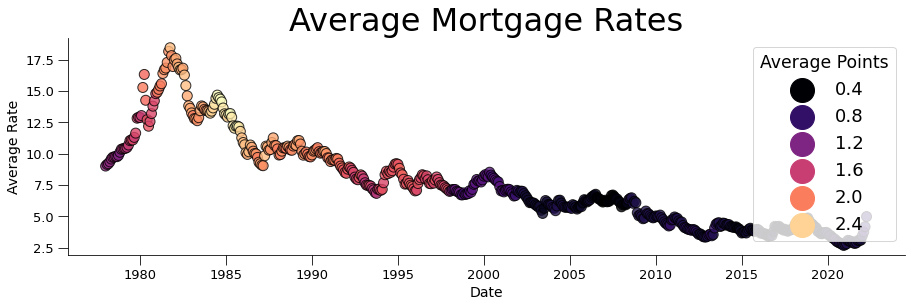

In [94]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.title_fontsize'] = 'xx-large'
fig = plt.figure(figsize = (15,4))
plt.title("Average Mortgage Rates", fontsize = 32)
ax = sns.scatterplot(data = monthly_mr,
                     x = 'Date',
                     y = 'AverageRate',
                     hue = 'AveragePoints',
                     palette = 'magma', 
                     s = 100,
                     alpha = .8, 
                     edgecolor = 'black', 
                     linewidth = 1,
                     legend = True)

ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Average Rate', fontsize = 14)
ax.tick_params(size = 10)
ax.legend(title = 'Average Points', fontsize = 18, markerscale = 4)
sns.despine()
plt.show()

In [82]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [92]:
monthly_mr.reset_index(inplace = True)
monthly_mr.dropna(inplace = True)

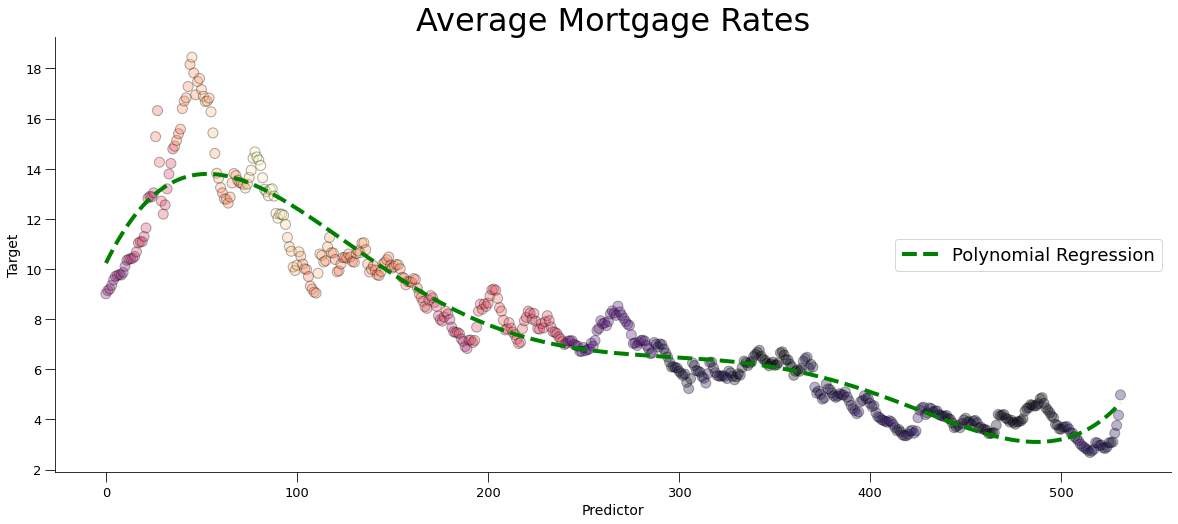

In [128]:
Input=[('polynomial', PolynomialFeatures(degree=5)),('modal',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(monthly_mr[['index']], monthly_mr[['AverageRate']])

poly_pred = pipe.predict(monthly_mr[['index']])

sorted_zip = sorted(zip(monthly_mr['index'], poly_pred))

x_poly, poly_pred = zip(*sorted_zip)

x = monthly_mr[['index']]
y = monthly_mr[['AverageRate']]

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
#plt.rcParams['legend.title_fontsize'] = 'xx-large'
fig = plt.figure(figsize = (20,8))
plt.title("Average Mortgage Rates", fontsize = 32)
ax = sns.scatterplot(data = monthly_mr,
                     x = 'index',
                     y = 'AverageRate',
                     hue = 'AveragePoints',
                     palette = 'magma', 
                     s = 100,
                     alpha = .32, 
                     edgecolor = 'black', 
                     linewidth = 1,
                     legend = False)

plt.plot(x_poly, poly_pred, color = 'green', linewidth = 4, linestyle= 'dashed', label = 'Polynomial Regression')

ax.set_xlabel('Predictor', fontsize = 14)
ax.set_ylabel('Target', fontsize = 14)
ax.tick_params(size = 10)
ax.legend(fontsize = 18, markerscale = 1, loc = 5)
sns.despine()
plt.show()

plt.show()